# Machine Learning Models Applied to the IDS-2017

The purpose of this notebook is to experiment different machine learning on the IDS-2017 dataset generated by the CICFlowMeter on the recorder traffic which included benign and malicious flows

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix
from notebook_utils import upsample_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

def replace_invalid(df):
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Identify columns with NaN, infinity, or negative values
    invalid_columns = df[numeric_columns].columns[df[numeric_columns].isna().any() |
                                                  np.isinf(df[numeric_columns]).any() |
                                                  (df[numeric_columns] < 0).any()]

    print("Columns with NaN, infinity, or negative values:", invalid_columns.tolist())
    
    # Replace invalid values with NaN and fill with column mean
    df[invalid_columns] = df[invalid_columns].replace([np.inf, -np.inf, -1], np.nan)
    df[invalid_columns] = df[invalid_columns].fillna(df[invalid_columns].mean())
    
    return df
    
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    convert_dict = {'label': 'category'}
    df = df.astype(convert_dict)
    replace_invalid(df)
    df.info()
    return df

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

# 1. Preparing the Dataset

In [2]:
df = load_dataset(file_path)

Columns with NaN, infinity, or negative values: ['flow_duration', 'flow_bytes_s', 'flow_packets_s', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_min', 'fwd_header_length', 'bwd_header_length', 'fwd_header_length_1', 'init_win_bytes_forward', 'init_win_bytes_backward', 'min_seg_size_forward']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                float64 
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length

In [3]:
X = df.iloc[:, 0:79]
Y = df.iloc[:, 79:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                float64
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  

# 2. Feature Selection

### Correlation based feature selection

First, the columns with no variance are dropped as they have no impact on the target variables.

In [4]:
stats = X.describe()
std = stats.loc["std"]
features_no_var = std[std == 0.0].index
# Exclude non-numeric columns (e.g., categorical columns) from the features with zero variance
features_no_var_numeric = [col for col in features_no_var if col in X.select_dtypes(include=[np.number]).columns]
print(features_no_var_numeric)

['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']


The destination port feature is dropped because it can act as a shortcut predictor and cause high overfitting for the training set as show in this [paper](https://link.springer.com/chapter/10.1007/978-3-031-09484-2_2)

In [5]:
X = X.drop(columns=features_no_var)
X = X.drop(columns=['destination_port'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 70 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                float64
 2   total_fwd_packets            int64  
 3   total_backward_packets       int64  
 4   total_length_of_fwd_packets  float64
 5   total_length_of_bwd_packets  float64
 6   fwd_packet_length_max        float64
 7   fwd_packet_length_min        float64
 8   fwd_packet_length_mean       float64
 9   fwd_packet_length_std        float64
 10  bwd_packet_length_max        float64
 11  bwd_packet_length_min        float64
 12  bwd_packet_length_mean       float64
 13  bwd_packet_length_std        float64
 14  flow_bytes_s                 float64
 15  flow_packets_s               float64
 16  flow_iat_mean                float64
 17  flow_iat_std                 float64
 18  flow_iat_max                 float64
 19  

### Remove collinear variables

In [6]:
threshold = 0.9
corr_matrix = X.corr().abs()
corr_matrix.head()

,protocol,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
protocol,1.000000,0.265288,0.007272,0.006361,0.033234,0.005191,0.166066,0.315250,0.052344,0.178832,...,0.005043,0.003451,0.085598,0.081018,0.109356,0.063663,0.179676,0.071305,0.184514,0.170531
flow_duration,0.265288,1.000000,0.020857,0.019669,0.065456,0.016186,0.273304,0.105235,0.143685,0.234434,...,0.015942,0.001357,0.189298,0.241059,0.294033,0.121169,0.768031,0.243153,0.779524,0.738325
total_fwd_packets,0.007272,0.020857,1.000000,0.999070,0.365508,0.996993,0.009358,0.002989,0.000032,0.001403,...,0.887387,0.000184,0.039937,0.008329,0.030459,0.041283,0.001820,0.000809,0.001906,0.001670
total_backward_packets,0.006361,0.019669,0.999070,1.000000,0.359451,0.994429,0.009039,0.002600,0.000333,0.001026,...,0.882566,0.000018,0.038963,0.006437,0.028602,0.041278,0.001425,0.000492,0.001456,0.001330
total_length_of_fwd_packets,0.033234,0.065456,0.365508,0.359451,1.000000,0.353762,0.197030,0.000275,0.185262,0.159787,...,0.407448,0.001209,0.101084,0.103326,0.126493,0.068325,0.022660,0.027064,0.026079,0.018634


In [7]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,protocol,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
protocol,NaN,0.265288,0.007272,0.006361,0.033234,0.005191,0.166066,0.315250,0.052344,0.178832,...,0.005043,0.003451,0.085598,0.081018,0.109356,0.063663,0.179676,0.071305,0.184514,0.170531
flow_duration,NaN,NaN,0.020857,0.019669,0.065456,0.016186,0.273304,0.105235,0.143685,0.234434,...,0.015942,0.001357,0.189298,0.241059,0.294033,0.121169,0.768031,0.243153,0.779524,0.738325
total_fwd_packets,NaN,NaN,NaN,0.999070,0.365508,0.996993,0.009358,0.002989,0.000032,0.001403,...,0.887387,0.000184,0.039937,0.008329,0.030459,0.041283,0.001820,0.000809,0.001906,0.001670
total_backward_packets,NaN,NaN,NaN,NaN,0.359451,0.994429,0.009039,0.002600,0.000333,0.001026,...,0.882566,0.000018,0.038963,0.006437,0.028602,0.041278,0.001425,0.000492,0.001456,0.001330
total_length_of_fwd_packets,NaN,NaN,NaN,NaN,NaN,0.353762,0.197030,0.000275,0.185262,0.159787,...,0.407448,0.001209,0.101084,0.103326,0.126493,0.068325,0.022660,0.027064,0.026079,0.018634


In [8]:
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_keep = [
    'Destination Port', 'Fwd Packet Length Std', 'Min Packet Length', 
    'Packet Length Variance', 'PSH Flag Count', 'Active Max'
]
to_drop = [column for column in to_drop if column not in to_keep]
print('There are %d columns to remove.' % (len(to_drop)))
X = X.drop(columns=to_drop)
X.info()

There are 31 columns to remove.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 39 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   protocol                     int64  
 1   flow_duration                float64
 2   total_fwd_packets            int64  
 3   total_length_of_fwd_packets  float64
 4   fwd_packet_length_max        float64
 5   fwd_packet_length_min        float64
 6   fwd_packet_length_mean       float64
 7   bwd_packet_length_max        float64
 8   bwd_packet_length_min        float64
 9   flow_bytes_s                 float64
 10  flow_packets_s               float64
 11  flow_iat_mean                float64
 12  flow_iat_std                 float64
 13  flow_iat_min                 float64
 14  fwd_iat_min                  float64
 15  bwd_iat_total                float64
 16  bwd_iat_mean                 float64
 17  bwd_iat_std                  float64
 18  bwd_iat_ma

### 3. Split Dataset

The dataset is split into a train, cross-validation and evaluation sets with a ratio of 0.8/0.1/0.1. The dataset is stratified according to the label to have an equal representation of all classes in the 3 subsets.

In [9]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)
X_eval, X_test, Y_eval, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp.label_code)

Upsampling is used to generate artificial samples for types of attacks that are underrepresented in the dataset.

In [10]:
X_train, Y_train = upsample_dataset(X, Y, 100000, attack_labels)

In [11]:
Y_train.label.value_counts()

label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [12]:
Y_eval.label.value_counts()

label
BENIGN                        227310
DoS Hulk                       23107
PortScan                       15893
DDoS                           12803
DoS GoldenEye                   1029
FTP-Patator                      794
SSH-Patator                      589
DoS slowloris                    579
DoS Slowhttptest                 550
Bot                              197
Web Attack - Brute Force         151
Web Attack - XSS                  65
Infiltration                       4
Web Attack - Sql Injection         2
Heartbleed                         1
Name: count, dtype: int64

In [13]:
Y_test.label.value_counts()

label
BENIGN                        227310
DoS Hulk                       23108
PortScan                       15893
DDoS                           12803
DoS GoldenEye                   1030
FTP-Patator                      794
SSH-Patator                      590
DoS slowloris                    580
DoS Slowhttptest                 550
Bot                              196
Web Attack - Brute Force         150
Web Attack - XSS                  65
Infiltration                       3
Web Attack - Sql Injection         2
Heartbleed                         1
Name: count, dtype: int64

Statistics for the training set

In [14]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.5842
is_attack
0.0    2273097
1.0    1618030
Name: count, dtype: int64


# 3. Machine Learning Classifiers

In this section, different machine learning models are applied to classify network traffic. The metrics used to evaluate the models are primarily accuracy, precision, recall and the F1 score.

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [16]:
def plot_confusion_matrix(model_name, Y_true, Y_pred, labels=["Benign", "Attack"]):
    matrix = confusion_matrix(Y_true.is_attack, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def metrics_report(dataset_type, y_true, y_predict, print_avg=True):
    print(f"Classification Report ({dataset_type}):")
    print(classification_report(y_true, y_predict, digits=4))
    if print_avg:
        print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    print("Accuracy:",accuracy_score(y_true, y_predict))
    res = classification_report(y_true, y_predict, digits=4, output_dict = True)
    res["accuracy"] = accuracy_score(y_true, y_predict)
    return res

In [17]:
performance_models = {}

#### Functions for saving and loading modules

In [18]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

## 3.1 Decision Trees/Ensembles Algorithms

### 3.1.1 Regression Forest

#### Binary Classification

In [19]:
rf_model_binary = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced', criterion="entropy", n_estimators = 300, bootstrap = True, max_features=None)
rf_model_binary.fit(scaler.transform(X_train), Y_train.is_attack)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 46.3min finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=None, n_estimators=300, n_jobs=-1,
                       verbose=1)

Evaluation Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.7s finished


Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     1.0000    0.9995    0.9997    227310
           1     0.9979    0.9999    0.9989     55764

    accuracy                         0.9996    283074
   macro avg     0.9989    0.9997    0.9993    283074
weighted avg     0.9996    0.9996    0.9996    283074

Avg Precision Score: 0.9978486651284253
Accuracy: 0.9995725499339395
Test Set Performance


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.7s finished


Classification Report (Test):
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997    227310
           1     0.9976    0.9999    0.9988     55765

    accuracy                         0.9995    283075
   macro avg     0.9988    0.9997    0.9992    283075
weighted avg     0.9995    0.9995    0.9995    283075

Avg Precision Score: 0.9975953147083236
Accuracy: 0.9995230945862404


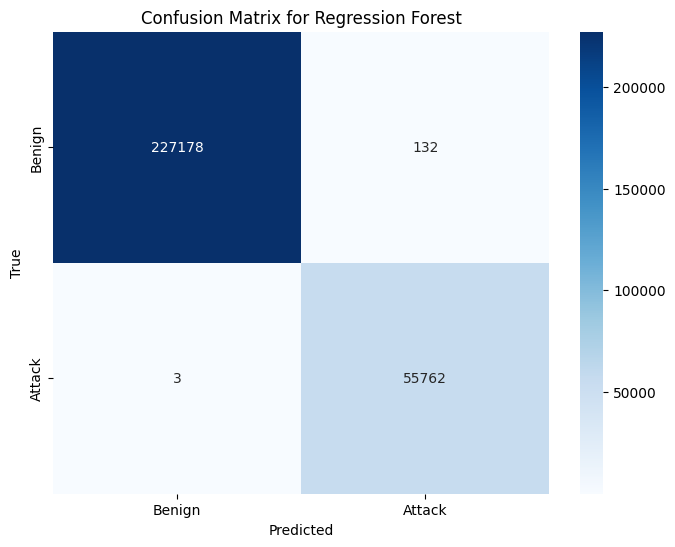

In [20]:
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, rf_model_binary.predict(scaler.transform(X_eval)))
# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = rf_model_binary.predict(scaler.transform(X_test))
performance_models["rf"] = metrics_report("Test", Y_test.is_attack, Y_pred)
plot_confusion_matrix("Regression Forest", Y_test, Y_pred)

In [21]:
save_model(rf_model_binary, 'random_forest')

Model saved to models/random_forest.pkl


#### Multi-class classifier

In [22]:
rf_model_multiclass = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
rf_model_multiclass.fit(scaler.transform(X_train), Y_train.label_code)
# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.label_code, rf_model_multiclass.predict(scaler.transform(X_eval)), print_avg=False)
# Predict and evaluate on the test set
print("Test Set Performance")
metrics_report("Test", Y_test.label_code, rf_model_multiclass.predict(scaler.transform(X_test)), print_avg=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Evaluation Set Performance


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.0s finished


Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     1.0000    0.9977    0.9988    227310
           1     0.3803    1.0000    0.5510       197
           2     0.9999    0.9998    0.9999     12803
           3     0.9990    1.0000    0.9995      1029
           4     0.9966    1.0000    0.9983     23107
           5     1.0000    1.0000    1.0000       550
           6     1.0000    0.9983    0.9991       579
           7     1.0000    1.0000    1.0000       794
           8     1.0000    1.0000    1.0000         1
           9     1.0000    1.0000    1.0000         4
          10     0.9943    0.9999    0.9971     15893
          11     1.0000    1.0000    1.0000       589
          12     0.7254    0.6821    0.7031       151
          13     0.6667    1.0000    0.8000         2
          14     0.5625    0.9692    0.7119        65

    accuracy                         0.9979    283074
   macro avg     0.8883    0.9765    0.9173 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.0s finished


Classification Report (Test):
              precision    recall  f1-score   support

           0     1.0000    0.9975    0.9988    227310
           1     0.3748    1.0000    0.5452       196
           2     0.9999    0.9999    0.9999     12803
           3     0.9990    1.0000    0.9995      1030
           4     0.9959    1.0000    0.9980     23108
           5     0.9964    0.9982    0.9973       550
           6     0.9983    1.0000    0.9991       580
           7     1.0000    1.0000    1.0000       794
           8     1.0000    1.0000    1.0000         1
           9     1.0000    1.0000    1.0000         3
          10     0.9931    0.9999    0.9965     15893
          11     1.0000    1.0000    1.0000       590
          12     0.8015    0.7000    0.7473       150
          13     1.0000    1.0000    1.0000         2
          14     0.5676    0.9692    0.7159        65

    accuracy                         0.9978    283075
   macro avg     0.9151    0.9777    0.9332    283

{'0': {'precision': 0.9999955898372209,
  'recall': 0.9975276054727025,
  'f1-score': 0.9987600730301569,
  'support': 227310.0},
 '1': {'precision': 0.37476099426386233,
  'recall': 1.0,
  'f1-score': 0.545201668984701,
  'support': 196.0},
 '2': {'precision': 0.9999218933062564,
  'recall': 0.9999218933062564,
  'f1-score': 0.9999218933062564,
  'support': 12803.0},
 '3': {'precision': 0.9990300678952473,
  'recall': 1.0,
  'f1-score': 0.9995147986414362,
  'support': 1030.0},
 '4': {'precision': 0.9959486251185242,
  'recall': 1.0,
  'f1-score': 0.9979702008205571,
  'support': 23108.0},
 '5': {'precision': 0.9963702359346642,
  'recall': 0.9981818181818182,
  'f1-score': 0.997275204359673,
  'support': 550.0},
 '6': {'precision': 0.9982788296041308,
  'recall': 1.0,
  'f1-score': 0.9991386735572783,
  'support': 580.0},
 '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 794.0},
 '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0},
 '9': {'precis

Given that the dataset lacks many samples for some of the attack types, the multiclass classifier has low accuracy for several attack types, even after upsampling, which will cause overfitting in this case. It is better to test other machine learning algorithms for binary classifiers.

### 3.1.2 Gradient Boost (XGB)

In [23]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Initialize the XGBoost classifier
xgb_model_binary = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=1, n_jobs=-1)

# Define the scorer
scorer = make_scorer(precision_score)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model_binary, param_distributions=param_grid, n_iter=20,
                                   scoring=scorer, n_jobs=-1, cv=2, verbose=2, random_state=42)

# Fit the model on the training data
random_search.fit(scaler.transform(X_train.astype('float32')), Y_train.is_attack)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}


Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}

In [24]:
best_params = random_search.best_params_

best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=1,
    n_jobs=-1,
    **best_params
)

# Fit the model on the training data
best_xgb_model.fit(scaler.transform(X_train), Y_train.is_attack)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

Evaluation Set Performance
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9998    0.9983    0.9990    227310
           1     0.9930    0.9991    0.9960     55764

    accuracy                         0.9984    283074
   macro avg     0.9964    0.9987    0.9975    283074
weighted avg     0.9984    0.9984    0.9984    283074

Accuracy: 0.9984279728975463
Test Set Performance
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9998    0.9982    0.9990    227310
           1     0.9927    0.9991    0.9959     55765

    accuracy                         0.9984    283075
   macro avg     0.9962    0.9987    0.9974    283075
weighted avg     0.9984    0.9984    0.9984    283075

Accuracy: 0.9983785215932174


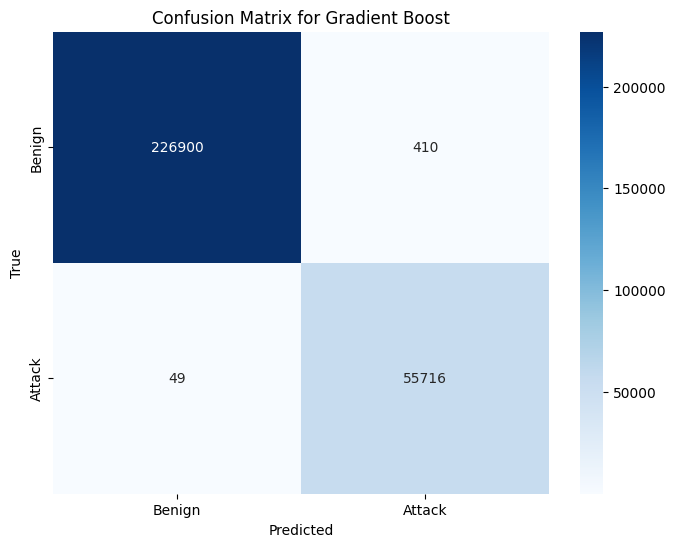

In [25]:
# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, best_xgb_model.predict(scaler.transform(X_eval)), print_avg=False)
# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = best_xgb_model.predict(scaler.transform(X_test))
performance_models["xgb"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)
plot_confusion_matrix("Gradient Boost", Y_test, Y_pred)


In [26]:
save_model(best_xgb_model, 'xgb_model')

Model saved to models/xgb_model.pkl


### 3.1.3 ADABoost

In [27]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost_model = AdaBoostClassifier(
    n_estimators=50,  # Number of weak learners
    learning_rate=1.0,  # Learning rate (contribution of each weak learner)
    algorithm='SAMME',  # SAMME.R is recommended for probability estimates
    random_state=42
)

# Fit the model on the training data
ada_boost_model.fit(scaler.transform(X_train), Y_train.is_attack)

AdaBoostClassifier(algorithm='SAMME', random_state=42)

Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9910    0.9221    0.9553    227310
           1     0.7525    0.9657    0.8459     55764

    accuracy                         0.9307    283074
   macro avg     0.8718    0.9439    0.9006    283074
weighted avg     0.9440    0.9307    0.9337    283074

Accuracy: 0.9306930343302457
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9915    0.9225    0.9557    227310
           1     0.7539    0.9677    0.8475     55765

    accuracy                         0.9314    283075
   macro avg     0.8727    0.9451    0.9016    283075
weighted avg     0.9447    0.9314    0.9344    283075

Accuracy: 0.9313927404398128


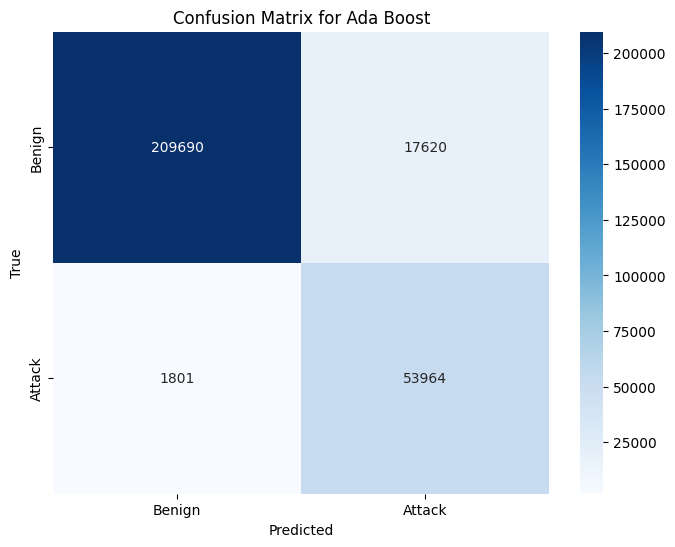

In [28]:
# Predict and evaluate on the evaluation set
y_pred_eval = ada_boost_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = ada_boost_model.predict(scaler.transform(X_test))
performance_models["adaboost"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("Ada Boost", Y_test, y_pred_test)

In [29]:
save_model(ada_boost_model, 'ada_boost_model')

Model saved to models/ada_boost_model.pkl


### 3.1.4 ID3

In [30]:
id3_model = DecisionTreeClassifier(
    criterion='entropy',  # Use entropy for ID3-like behavior
    max_depth=None,  # Unlimited depth (ID3 doesn't prune trees)
    random_state=42
)

# Fit the model on the training data
id3_model.fit(scaler.transform(X_train), Y_train.is_attack)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     1.0000    0.9995    0.9997    227310
           1     0.9980    0.9999    0.9989     55764

    accuracy                         0.9996    283074
   macro avg     0.9990    0.9997    0.9993    283074
weighted avg     0.9996    0.9996    0.9996    283074

Accuracy: 0.9995760825791136
Classification Report (Test):
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997    227310
           1     0.9977    0.9999    0.9988     55765

    accuracy                         0.9995    283075
   macro avg     0.9988    0.9997    0.9992    283075
weighted avg     0.9995    0.9995    0.9995    283075

Accuracy: 0.9995230945862404


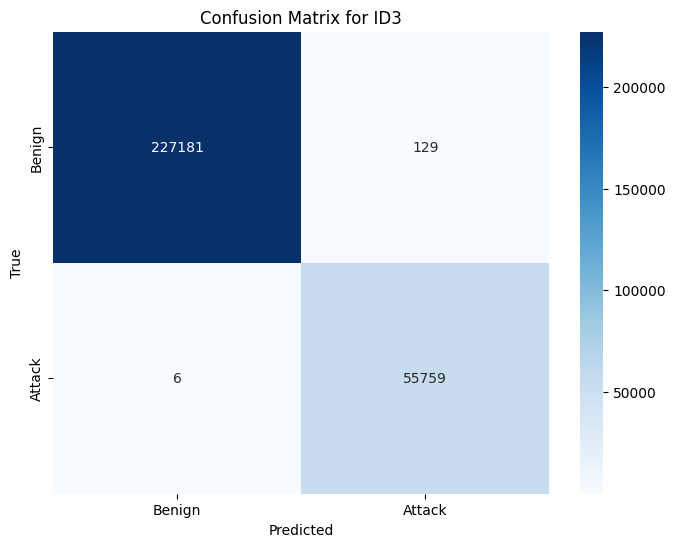

In [31]:
y_pred_eval = id3_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = id3_model.predict(scaler.transform(X_test))
performance_models["id3"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("ID3", Y_test, y_pred_test)

In [32]:
save_model(id3_model, 'id3_model')

Model saved to models/id3_model.pkl


### Conclusion

[0.9995230945862404, 0.9983785215932174, 0.9313927404398128, 0.9995230945862404]
['rf', 'xgb', 'adaboost', 'id3']


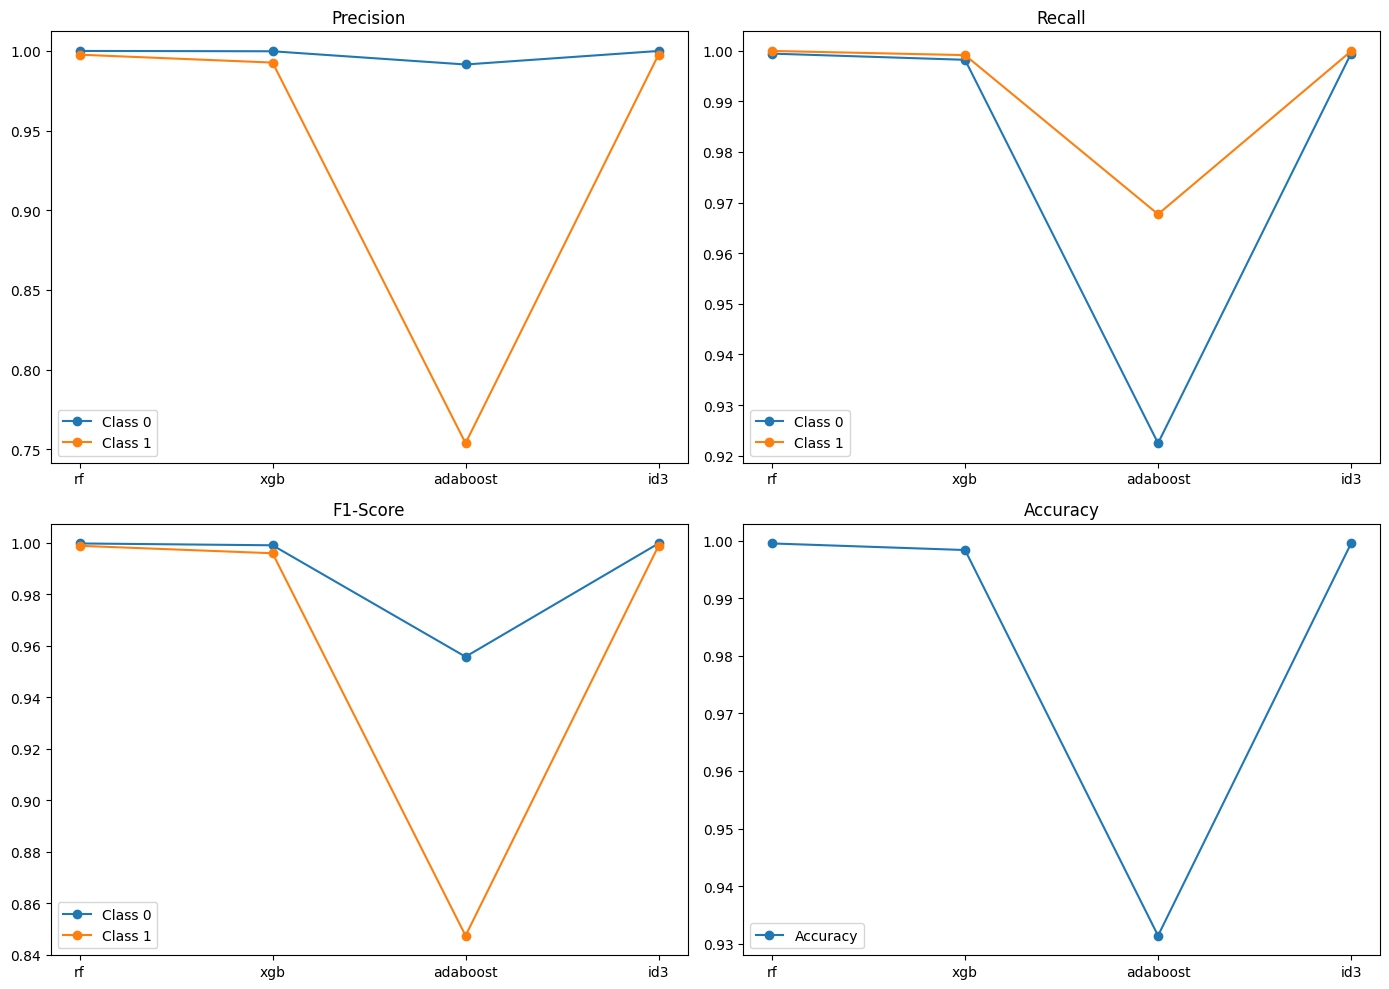

In [33]:
def extract_and_plot_metrics(metrics_dict):
    # Initialize dictionaries to store the metrics for plotting
    precision_dict = {'0': [], '1': [], 'model': []}
    recall_dict = {'0': [], '1': [], 'model': []}
    f1_score_dict = {'0': [], '1': [], 'model': []}
    accuracy_list = []

    # Iterate over the models in the metrics dictionary
    for model_name, metrics in metrics_dict.items():
        precision_dict['0'].append(metrics['0']['precision'])
        precision_dict['1'].append(metrics['1']['precision'])
        recall_dict['0'].append(metrics['0']['recall'])
        recall_dict['1'].append(metrics['1']['recall'])
        f1_score_dict['0'].append(metrics['0']['f1-score'])
        f1_score_dict['1'].append(metrics['1']['f1-score'])
        accuracy_list.append(metrics['accuracy'])
        precision_dict['model'].append(model_name)
        recall_dict['model'].append(model_name)
        f1_score_dict['model'].append(model_name)
        
    # Plotting the metrics
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot precision
    axs[0, 0].plot(precision_dict['model'], precision_dict['0'], label='Class 0', marker='o')
    axs[0, 0].plot(precision_dict['model'], precision_dict['1'], label='Class 1', marker='o')
    axs[0, 0].set_title('Precision')
    axs[0, 0].legend()
    
    # Plot recall
    axs[0, 1].plot(recall_dict['model'], recall_dict['0'], label='Class 0', marker='o')
    axs[0, 1].plot(recall_dict['model'], recall_dict['1'], label='Class 1', marker='o')
    axs[0, 1].set_title('Recall')
    axs[0, 1].legend()
    
    # Plot f1-score
    axs[1, 0].plot(f1_score_dict['model'], f1_score_dict['0'], label='Class 0', marker='o')
    axs[1, 0].plot(f1_score_dict['model'], f1_score_dict['1'], label='Class 1', marker='o')
    axs[1, 0].set_title('F1-Score')
    axs[1, 0].legend()
    
    # Plot accuracy
    print(accuracy_list)
    print(precision_dict['model'])
    axs[1, 1].plot(precision_dict['model'], accuracy_list, label='Accuracy', marker='o')
    axs[1, 1].set_title('Accuracy')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

extract_and_plot_metrics(performance_models)

ID3 and Random Forest perform very well on the dataset while Adaboost is the worst model. To conclude, after finetuning the hyperparameters, random forest seems to be the best tree based algorithm to perform on the dataset. 

## 3.2 Deep Neural Network

In this section, deep neural networks are used to create binary classifiers that distinguish between benign and malicious traffics. Hyperparameters are optimized to obtain the best results.

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [35]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(scaler.transform(X_train).shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(scaler.transform(X_train), Y_train.is_attack, epochs=10, batch_size=32, validation_split=0.2)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 66s 673us/step - accuracy: 0.9374 - loss: 0.1676 - val_accuracy: 0.2848 - val_loss: 8.9642
Epoch 2/10
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 66s 678us/step - accuracy: 0.9524 - loss: 0.1146 - val_accuracy: 0.2882 - val_loss: 7.4969
Epoch 3/10
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 669us/step - accuracy: 0.9544 - loss: 0.1118 - val_accuracy: 0.2889 - val_loss: 4.7225
Epoch 4/10
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 664us/step - accuracy: 0.9557 - loss: 0.1169 - val_accuracy: 0.2726 - val_loss: 10.9780
Epoch 5/10
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 661us/step - accuracy: 0.9562 - loss: 0.1089 - val_accuracy: 0.3051 - val_loss: 6.2204
Epoch 6/10
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 666us/step - accuracy: 0.9568 - loss: 0.1259 - val_accuracy: 0.3020 - val_loss: 9.3219
Epoch 7/10
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 666us/step - accuracy: 0.9570 - loss: 0.1114 - val_accuracy: 0.2990 - val_loss: 11.0146
Epoch 8/10
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 666us

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 420us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9813    0.9796    0.9805    227310
           1     0.9175    0.9239    0.9207     55764

    accuracy                         0.9686    283074
   macro avg     0.9494    0.9518    0.9506    283074
weighted avg     0.9687    0.9686    0.9687    283074

Accuracy: 0.9686477740802758
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 433us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9818    0.9798    0.9808    227310
           1     0.9185    0.9260    0.9222     55765

    accuracy                         0.9692    283075
   macro avg     0.9501    0.9529    0.9515    283075
weighted avg     0.9693    0.9692    0.9693    283075

Accuracy: 0.9692307692307692


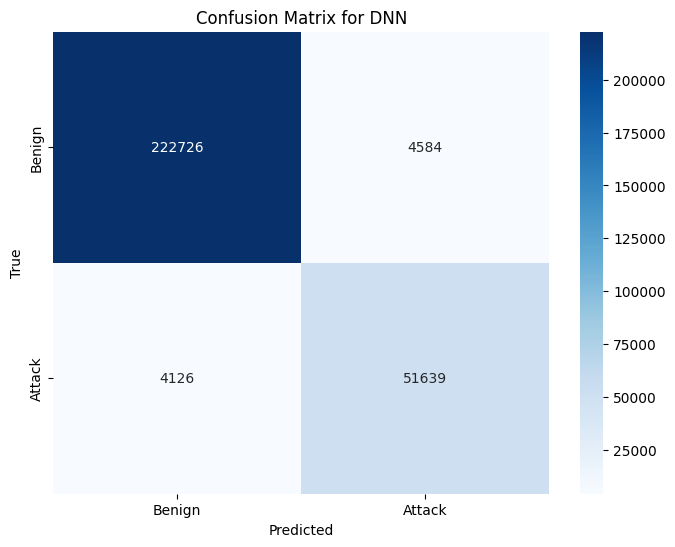

In [36]:
# Predict probabilities on the evaluation set
y_pred_eval_prob = model.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)

### Hyperparameter Tuning

In [37]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [52]:
from keras_tuner import RandomSearch

directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning')
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection'
)

tuner.search_space_summary()

# Perform the search
tuner.search(scaler.transform(X_train), Y_train.is_attack, epochs=10, validation_split=0.2)

Reloading Tuner from G:\Other computers\My PC\stage\ML-NIDS\Notebooks\hyperparam_tuning\intrusion_detection\tuner0.json
Search space summary
Default search space size: 9
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step'

In [39]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)
model1 = build_model(best_hps)
history = model.fit(scaler.transform(X_train), Y_train.is_attack, epochs=20, validation_split=0.2, verbose=1)

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 667us/step - accuracy: 0.9579 - loss: 0.1334 - val_accuracy: 0.3554 - val_loss: 5.8488
Epoch 2/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 668us/step - accuracy: 0.9580 - loss: 0.1261 - val_accuracy: 0.3384 - val_loss: 7.1888
Epoch 3/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 670us/step - accuracy: 0.9584 - loss: 0.1040 - val_accuracy: 0.3418 - val_loss: 4.9406
Epoch 4/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 668us/step - accuracy: 0.9583 - loss: 0.1237 - val_accuracy: 0.3384 - val_loss: 5.9503
Epoch 5/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 668us/step - accuracy: 0.9586 - loss: 0.1698 - val_accuracy: 0.3462 - val_loss: 6.6066
Epoch 6/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 666us/step - accuracy: 0.9587 - loss: 0.1062 - val_accuracy: 0.3664 - val_loss: 6.7357
Epoch 7/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 668us/step - accuracy: 0.9586 - loss: 0.1191 - val_accuracy: 0.3445 - val_loss: 6.9325
Epoch 8/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 667us/s

In [40]:
print(best_hps.values)

{'units_input': 480, 'num_layers': 2, 'units_0': 448, 'dropout_0': 0.30000000000000004, 'learning_rate': 0.00614260757976685, 'units_1': 224, 'dropout_1': 0.0, 'units_2': 256, 'dropout_2': 0.4}


In [41]:
from tensorflow.keras.models import save_model as save_model_keras

def save_keras_model(model, model_name):
    file_path = f'models/{model_name}.h5'
    save_model_keras(model, file_path)
    print(f'Model saved to {file_path}')

save_keras_model(model, 'DNN_model1')

Model saved to models/DNN_model1.h5


#### Best Hyperparameters
{'units_input': 480, 'num_layers': 2, 'units_0': 448, 'dropout_0': 0.30000000000000004, 'learning_rate': 0.00614260757976685, 'units_1': 224, 'dropout_1': 0.0, 'units_2': 256, 'dropout_2': 0.4}

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 424us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9833    0.9737    0.9785    227310
           1     0.8969    0.9326    0.9144     55764

    accuracy                         0.9656    283074
   macro avg     0.9401    0.9531    0.9464    283074
weighted avg     0.9663    0.9656    0.9658    283074

Accuracy: 0.9655920360047197
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 446us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9838    0.9738    0.9788    227310
           1     0.8976    0.9348    0.9158     55765

    accuracy                         0.9662    283075
   macro avg     0.9407    0.9543    0.9473    283075
weighted avg     0.9669    0.9662    0.9664    283075

Accuracy: 0.9661503135211517


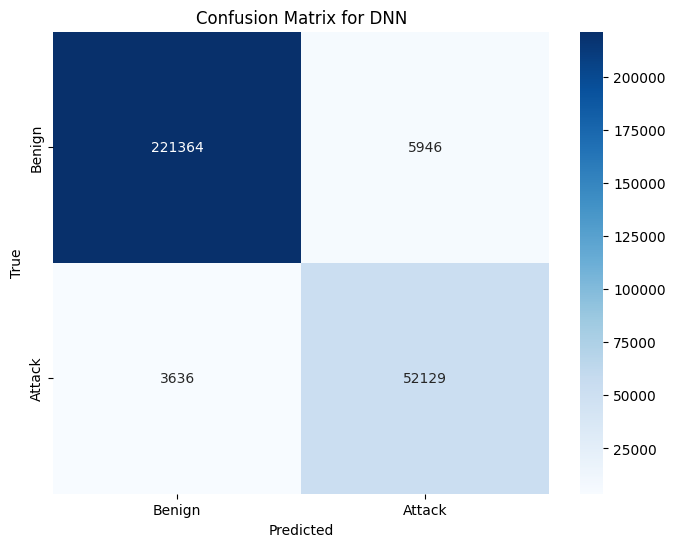

In [42]:
# Predict probabilities on the evaluation set
y_pred_eval_prob = model.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)
# Predict and evaluate on the test set
y_pred_test_prob = model.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)